# Create a feature engineering pipeline

In Section 1, you tabularized a sales time series dataset to forecast sales for the next week.

In this assignment, your task is to line up those feature engineering steps within a pipeline to directly obtain the features from the input data and then forecast sales using Lasso.

The most straightforward method is probably to use the open-source library Feature-engine. But you are welcome to use other libraries, code your transformers manually, or, why not, code our own pipeline?

To prepare the dataset for this assignment, please follow the guidelines in the notebook `02-create-online-retail-II-datasets.ipynb` in the `01-Create-Datasets` folder.

In [163]:
# imports
import pandas as pd
import numpy as np

from feature_engine.creation import CyclicalFeatures
from feature_engine.datetime import DatetimeFeatures
from feature_engine.imputation import DropMissingData
from feature_engine.selection import DropFeatures
from feature_engine.timeseries.forecasting import (
    LagFeatures,
    WindowFeatures,
)

from sklearn.pipeline import Pipeline
from sklearn.linear_model import Lasso
from sklearn.metrics import mean_squared_error

import matplotlib.pyplot as plt

In [164]:
# load weekly sales dataset

# Adjust the following function based on where 
# you stored the dataset
filename = "../../Datasets/online_retail_dataset.csv"

df = pd.read_csv(
    filename,
    usecols=["week", "United Kingdom"],
    parse_dates=["week"],
    index_col=["week"],
)

df.columns = ['sales']

df.head()

,sales
week,
2009-12-06,213000.35
2009-12-13,195810.04
2009-12-20,182396.74
2009-12-27,22007.77
2010-01-03,0.00


## Plot time series

<Axes: xlabel='week'>

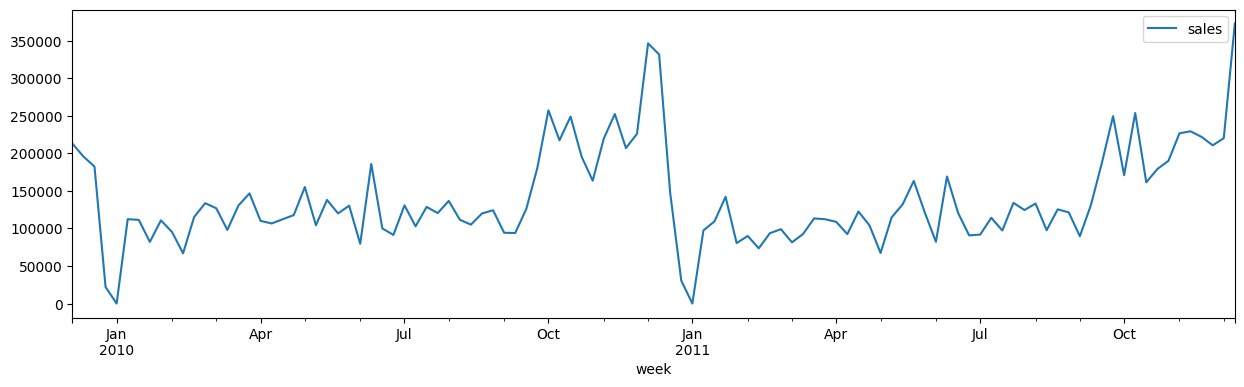

In [165]:
df.plot(figsize=[15, 4])

## Feature engineering

These are the feature engineering steps that you need to fit into a pipeline:

- Datetime features: Create the feature **month** from the timestamp.
- Cyclical features: transform the month with the sine and cosine functions.
- Lag features: Create the feature lag-1 by lagging 1 week of data.
- Window features: take the min, max and average sales values in the past 2 and 4 weeks of data.
- Drop missing data.

First set up suitable transformers / transformations and make sure they work.

In [166]:
# Create the feature month from the timestamp.
dtf = DatetimeFeatures(
    variables='index',
    features_to_extract=['month']
)

# fit input data into transformer
df = dtf.fit_transform(df)

In [167]:
# Transform the month with the sine and cosine functions
cyclicf = CyclicalFeatures(
    variables=['month'],
    drop_original=False
)

# fit input data into transformer
df = cyclicf.fit_transform(df)

In [168]:
# Create the feature lag-1 by lagging 1 week of data.
lagf = LagFeatures(
    variables='sales',
    freq=['1W'],
    missing_values='ignore'
)

# fit input data into transformer
df = lagf.fit_transform(df)

In [169]:
# Here we take the average, maximum, and minimum values
# of the previous 2 and 4 weeks.
winf = WindowFeatures(
    variables='sales',                  # using this column to create the window features.
    window=[2,4],                       # taking previous 2 and 4 weeks. refer to pandas.rolling()
    periods=1,                          # how many weeks you want to shift the agg values. refer to pands.shift()
    freq='W',                           # telling WindowFeatures to shift by 1 week. refer to pandas.shift()
    missing_values='ignore',
    functions=['mean', 'max', 'min']    # aggregation methods to apply on 'sales'
)

# fit the input data intor transformer
df = winf.fit_transform(df)

In [170]:
# Drop missing data.
drop_missing = DropMissingData()

# fit input data into transformer
df = drop_missing.fit_transform(df)

In [171]:
# Drop original time series
drop_ts = DropFeatures(features_to_drop='sales')

# fit input data into transformer
df = drop_ts.fit_transform(df)

## ML Workflow

- Load the data again.
- Split the data into a suitable train and test set.
- Align all feature engineering steps in a pipeline.
- Create the features.
- Train a model.
- Evaluate the model.

## Load the data

In [172]:
# load weekly sales dataset

# adjust the following function based on where 
# you stored the dataset
filename = "../../Datasets/online_retail_dataset.csv"

df = pd.read_csv(
    filename,
    usecols=["week", "United Kingdom"],
    parse_dates=["week"],
    index_col=["week"],
)

df.columns = ['sales']

df.head()

,sales
week,
2009-12-06,213000.35
2009-12-13,195810.04
2009-12-20,182396.74
2009-12-27,22007.77
2010-01-03,0.00


## Split data into train and test set

In [173]:
df.index.min(), df.index.max()

(Timestamp('2009-12-06 00:00:00'), Timestamp('2011-12-11 00:00:00'))

In [191]:
# The offset for the test set

# we need to leave out data after last week of sept as validation set
cut_off_point = "2011-09-30"

In [192]:
# Split the data in time.
X_train = df[df.index <= cut_off_point]
X_test = df[df.index > cut_off_point]

In [194]:
# Target (in this dataset, is is the train set itself)
y_train = X_train.sales
y_test = X_test.sales

## Feature Engineering Pipeline

In [195]:
# Create the feature month from the timestamp.
dtf = DatetimeFeatures(
    variables='index',
    features_to_extract=['month']
)

# Transform the month with the sine and cosine functions
cyclicf = CyclicalFeatures(
    variables=['month'],
    drop_original=False
)

# Create the feature lag-1 by lagging 1 week of data.
lagf = LagFeatures(
    variables='sales',
    freq=['1W'],
    missing_values='ignore'
)

# Here we take the average, maximum, and minimum values
# of the previous 2 and 4 weeks.
winf = WindowFeatures(
    variables='sales',                  # using this column to create the window features.
    window=[2,4],                       # taking previous 2 and 4 weeks. refer to pandas.rolling()
    periods=1,                          # how many weeks you want to shift the agg values. refer to pands.shift()
    freq='W',                           # telling WindowFeatures to shift by 1 week. refer to pandas.shift()
    missing_values='ignore',
    functions=['mean', 'max', 'min']    # aggregation methods to apply on 'sales'
)

# Drop missing data.
drop_missing = DropMissingData()

# Drop original time series
drop_ts = DropFeatures(features_to_drop='sales')

# initialise the pipeline
pipe = Pipeline(
    [
        ('datetime_features', dtf),
        ('cyclical_features', cyclicf),
        ('lag_features', lagf),
        ('window_features', winf),
        ('drop_missing', drop_missing),
        ('drop_time_series', drop_ts)
    ]
)

In [196]:
# fit training data into the pipeline and create features
pipe = pipe.fit(X_train)
X_train_t = pipe.transform(X_train)

# align y_train with the newly feature engineered X_train
y_train_t = y_train.loc[X_train_t.index]

In [197]:
# fit testing data into the pipeline and create features
X_test_t = pipe.transform(X_test)

# align y_test with the newly feature engineered X_test
y_test_t = y_test.loc[X_test_t.index]

## Machine Learning

In [198]:
# naive forecast
print("train rmse: ", mean_squared_error(
    y_train_t, X_train_t['sales_lag_1W'], squared=False,))

print("test rmse: ",  mean_squared_error(
    y_test_t, X_test_t['sales_lag_1W'], squared=False,))

train rmse:  45844.30745262792
test rmse:  59848.451942267486


In [199]:
linear_model = Lasso(alpha=100, random_state=0)

linear_model.fit(X_train_t, y_train_t)

# Performance of linear model

print("train rmse: ", mean_squared_error(
    y_train_t, linear_model.predict(X_train_t), squared=False,))

print("test rmse: ",  mean_squared_error(
    y_test_t, linear_model.predict(X_test_t), squared=False,))

train rmse:  34951.49054475681
test rmse:  48673.629497461894


Text(0.5, 0, 'Input Features')

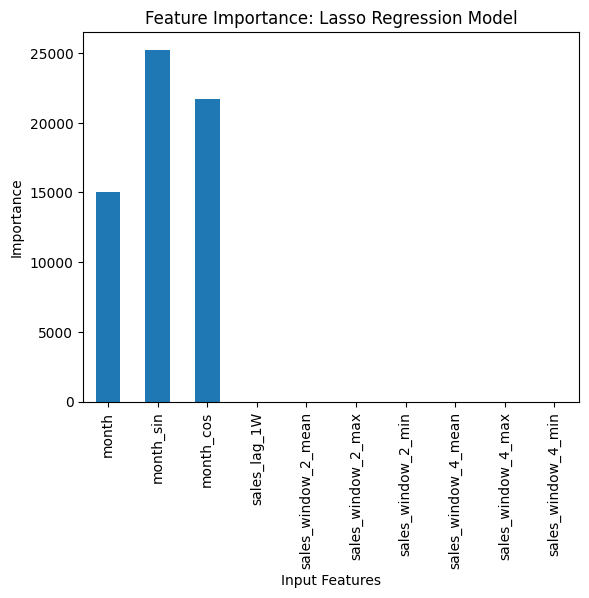

In [200]:
# features with the highest absolute coef_ value are considered the most important
model_coef = pd.Series(np.abs(linear_model.coef_))
model_coef.index = X_train_t.columns

# plot the model coef_ in a bar chart
model_coef.plot.bar()
plt.title('Feature Importance: Lasso Regression Model')
plt.ylabel('Importance')
plt.xlabel('Input Features')